In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft,dct
import librosa
from scipy import signal
import librosa.display
import soundfile as sf
import sounddevice as sd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import os

#### Feature Extraction

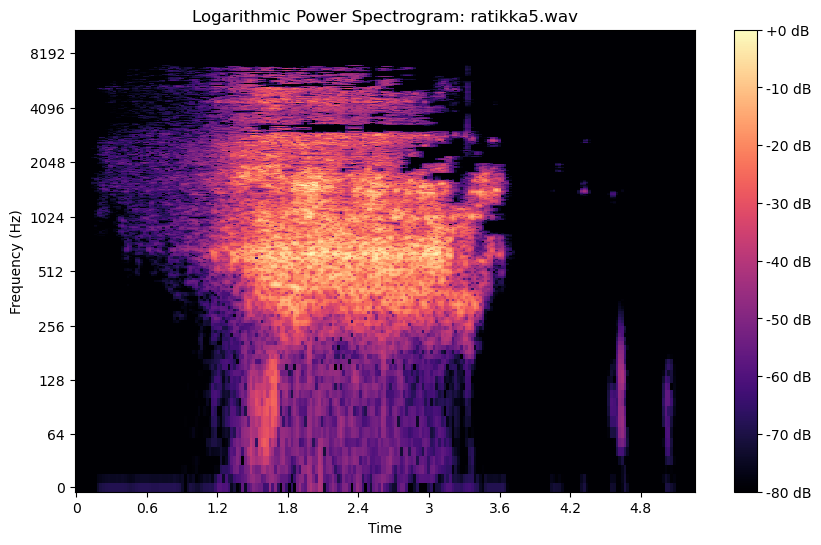

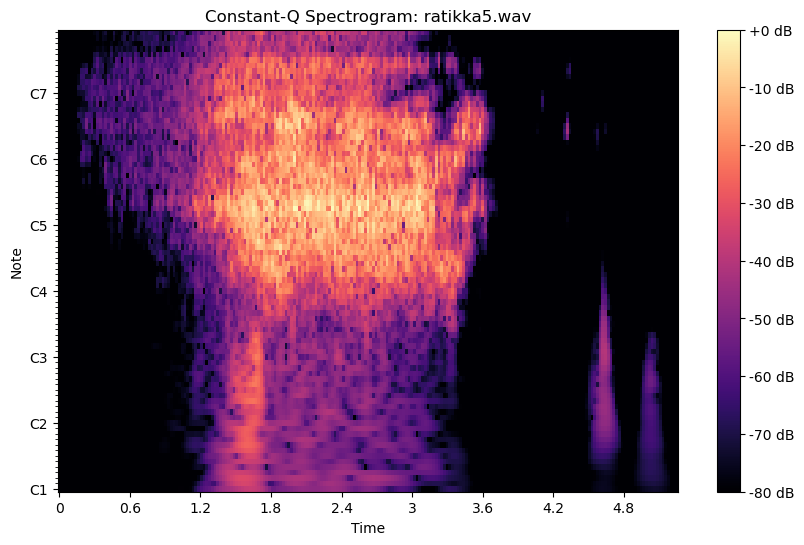

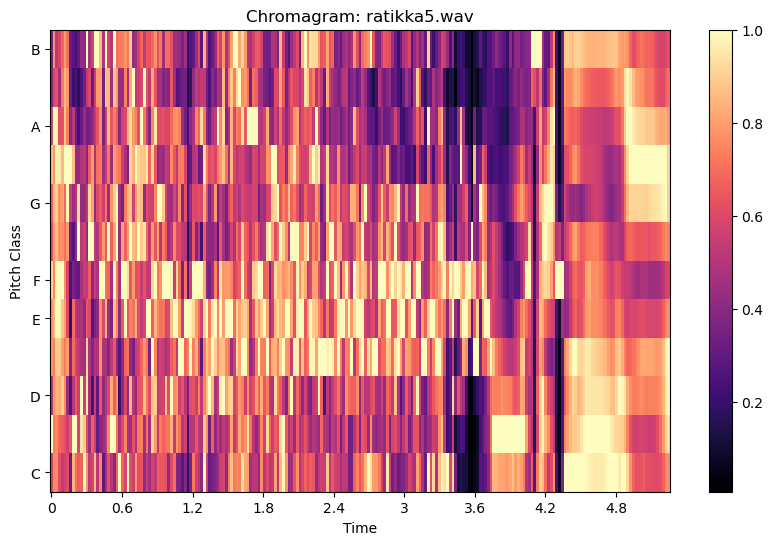

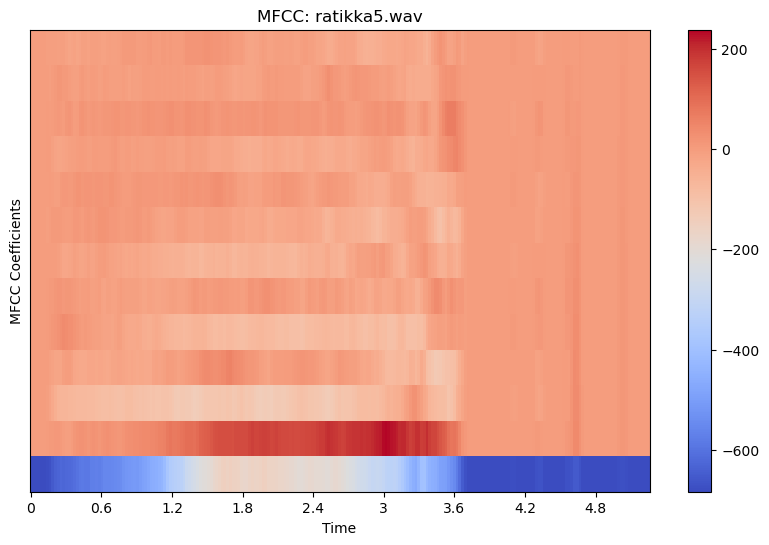

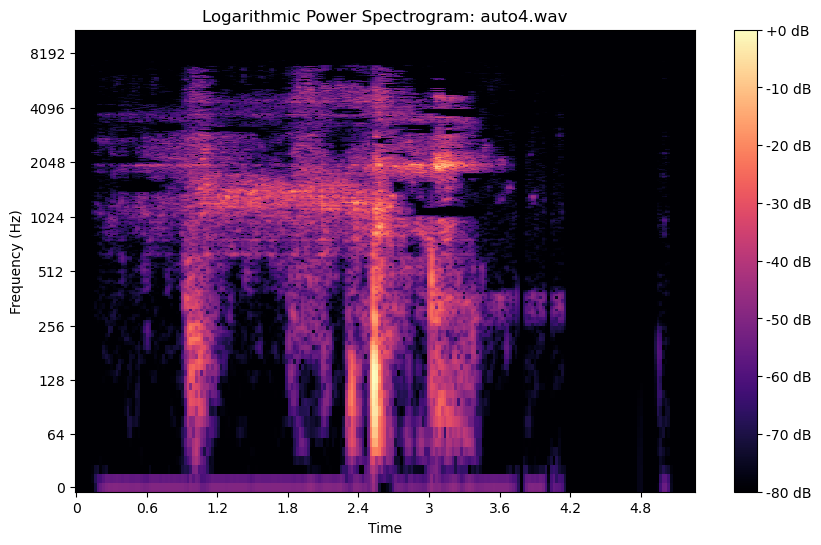

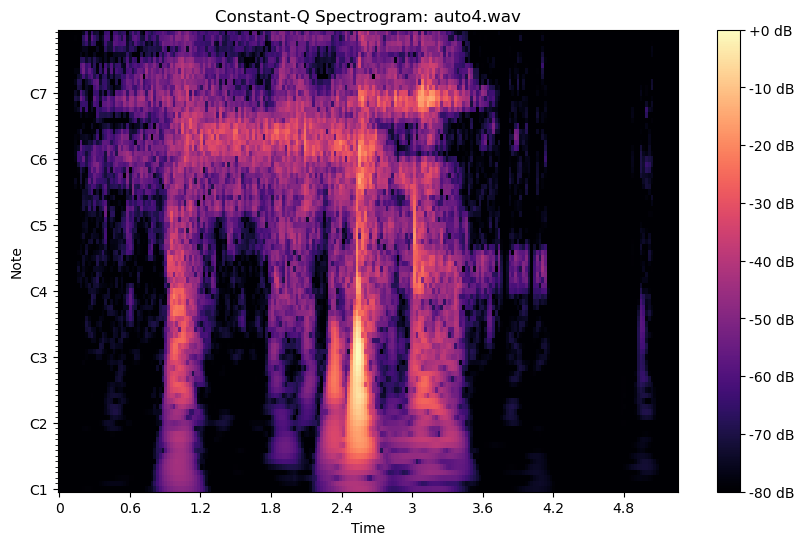

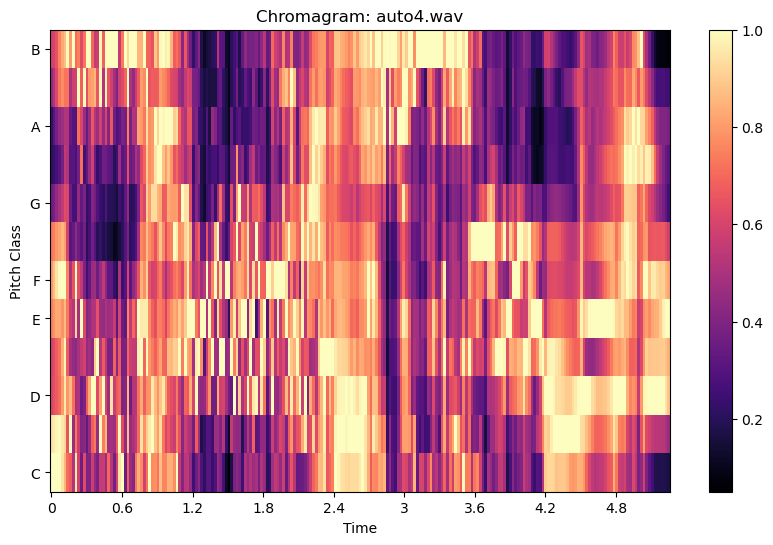

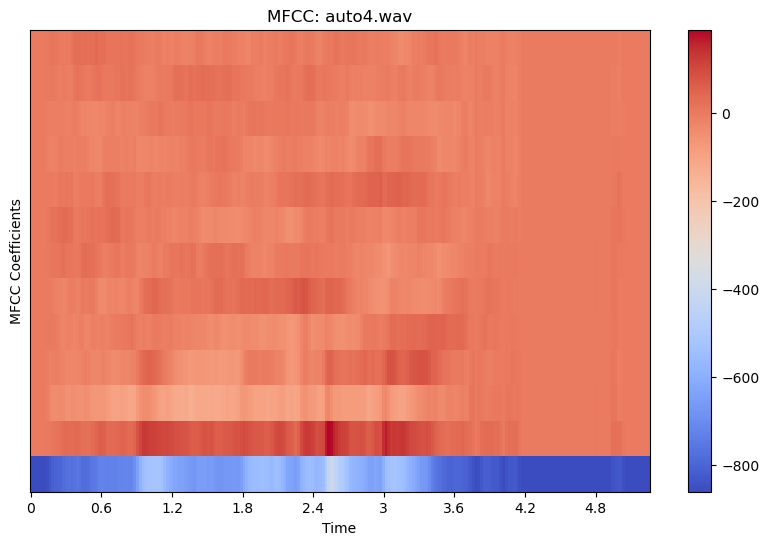

In [7]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

def feature_extraction(audio_file):

    # load the audio file
    audio, sr = librosa.load(audio_file)
    
    # calculate the features
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    log_spectrogram = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
    constant_q = librosa.amplitude_to_db(np.abs(librosa.cqt(audio, sr=sr)), ref=np.max)
    chroma = librosa.feature.chroma_cqt(y=audio, sr=sr)

    # 1. Logarithmic Power Spectrogram
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(log_spectrogram, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format="%+2.0f dB")
    plt.title(f"Logarithmic Power Spectrogram: {audio_file}")
    plt.xlabel("Time")
    plt.ylabel("Frequency (Hz)")
    plt.show()

    # 2. Constant-Q Spectrogram
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(constant_q, sr=sr, x_axis='time', y_axis='cqt_note')
    plt.colorbar(format="%+2.0f dB")
    plt.title(f"Constant-Q Spectrogram: {audio_file}")
    plt.xlabel("Time")
    plt.ylabel("Note")
    plt.show()

    # 3. Chromagram
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(chroma, x_axis='time', y_axis='chroma')
    plt.colorbar()
    plt.title(f"Chromagram: {audio_file}")
    plt.xlabel("Time")
    plt.ylabel("Pitch Class")
    plt.show()

    # 4. MFCC
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(mfccs, x_axis='time')
    plt.colorbar()
    plt.title(f"MFCC: {audio_file}")
    plt.xlabel("Time")
    plt.ylabel("MFCC Coefficients")
    plt.show()

# calling the function for two audio files
feature_extraction('ratikka5.wav')
feature_extraction('auto4.wav')

#### code for our model

In [2]:
import librosa
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

# --- Function for Calculating MFCC Features ---
def extract_features(audio_folder, output_csv, num_mfcc=13):
    data = []

    for filename in os.listdir(audio_folder):
        if filename.endswith(".wav"):
            file_path = os.path.join(audio_folder, filename)
            
            try:
                y, sr = librosa.load(file_path, duration=5)  # Loading at most 5 second long part
                mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=num_mfcc)
                mfccs_mean = np.mean(mfccs, axis=1)  # the mean of MFCC values
                
                # Adding the file name and the features
                data.append([filename] + mfccs_mean.tolist())
            
            except Exception as e:
                print(f"Error processing {file_path}: {e}")

    # Make the DataFrame and save as CSV 
    columns = ["filename"] + [f"mfcc_{i+1}" for i in range(num_mfcc)]
    df = pd.DataFrame(data, columns=columns)
    df.to_csv(output_csv, index=False)
    print(f"Features saved in a file: {output_csv}")

# --- Paths for the folders ---
train_folder = "C:\\Users\\tiiaj\\Desktop\\audio"
test_folder = "C:\\Users\\tiiaj\\Desktop\\audio\\ratikka"

# --- Save the features as CSV ---
extract_features(train_folder, "train_features.csv")
extract_features(test_folder, "test_features.csv")

# --- Read the CSV files  ---
train_df = pd.read_csv("train_features.csv")
test_df = pd.read_csv("test_features.csv")

# --- Add the label colums by the file names  ---
train_df['label'] = train_df['filename'].apply(lambda x: 'car' if 'car' in x else 'tram')
test_df['label'] = test_df['filename'].apply(lambda x: 'car' if 'auto' in x else 'tram' if 'ratikka' in x else 'unknown')

# --- Split the features (X) and the labels (y) ---
X = train_df.drop(columns=['filename', 'label'])
y = train_df['label']

X_test = test_df.drop(columns=['filename', 'label'])
y_test = test_df['label']

# --- Split the teaching data as teaching- and valdation data ---
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# --- Scale the data ---
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


# --- Train the KNN-model evaluate it with the validation data ---
best_k = 0
best_score = 0

for k in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    score = knn.score(X_val, y_val)
    print(f"K = {k}, The accuracy of the validation: {score:.2f}")
    if score > best_score:
        best_k = k
        best_score = score

print(f"\nThe best K: {best_k} with the accuracy {best_score:.2f}")

# --- Train the final model with the best k-value  ---
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)

# --- Predict with the test ---
y_pred = knn.predict(X_test)

# --- Print the Classification report with test data ---
print("\nClassification report with test data:")
print(classification_report(y_test, y_pred))


Features saved in a file: train_features.csv
Features saved in a file: test_features.csv
K = 1, The accuracy of the validation: 1.00
K = 2, The accuracy of the validation: 1.00
K = 3, The accuracy of the validation: 1.00
K = 4, The accuracy of the validation: 1.00
K = 5, The accuracy of the validation: 1.00
K = 6, The accuracy of the validation: 1.00
K = 7, The accuracy of the validation: 1.00
K = 8, The accuracy of the validation: 1.00
K = 9, The accuracy of the validation: 1.00
K = 10, The accuracy of the validation: 1.00

The best K: 1 with the accuracy 1.00

Classification report with test data:
              precision    recall  f1-score   support

         car       0.47      0.44      0.46        18
        tram       0.52      0.55      0.54        20

    accuracy                           0.50        38
   macro avg       0.50      0.50      0.50        38
weighted avg       0.50      0.50      0.50        38

